# <img style="float: left; padding-right: 10px; width: 45px" src="img/summer_school.png"> S-109A Introduction to Data Science 


## Lab 5: Ensembling methods

**Harvard University**<br>
**Summer 2021**<br>
**Instructor:** Kevin Rader<br>
**Notebook Authors:** Will Claybaugh, David Sondak, Kevin Rader, Chris Gumb

---

## <font color='red'> Run the cell below to properly highlight the exercises</font>

In [3]:
from IPython.display import HTML
style = "<style>"+\
    "div.exercise { background-color: #bf6cf1;border-color: #E9967A; border-left: 5px solid #800080; padding: 0.5em;}"+\
    "div.discussion { background-color: #90EE90;border-color: #E9967A; border-left: 5px solid #800080; padding: 0.5em;}"+\
    "</style>"
HTML(style)

## Learning Goals
After this lab, you should be able to:
- Discuss when combining several models could help improve overall accuracy
- Tune across multiple hyperparameters using cross_val_scores, GridSearchCV, or ParamGrid
- Explain why boosting and bagging are particularly effective versions of ensembling

In [4]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from IPython import display
%matplotlib inline

## Part 0: Jellybeans?
<img src='img/jelly_beans.jpg' style='width:200px;'>

Imagine we'd brought a jar of jelly beans to lab today and asked everyone to guess how many are in the jar. Whoever guesses closest to the exact number of jelly beans gets to keep them all! (If several people are the same distance from the truth, they split the jar equally.)

In this example, the members of the class play the role of a single model/estimator, and by combining the class's predictions we get a more accurate overall estimate. When we combine multiple models, it's called _ensembling_. 

We can learn a lot about ensembling by imagining a group of people all guessing how many beans are in a jar. What features would we want those people to have? What biases or pathologies could ruin the overall ensemble?

<div class="discussion"><b>Discussion</b></div>

**Q0.1** What happens to the combined guess if each member of the class makes the same kind of mistakes?

**Answer:**

If guesses are biased in the same way then averaging over them will not help remove it.

**Q0.2** What happens if the class is all clones and all make the same guess?

**Answer:**

If all guesses are the same, then there is no benefit considering multiple guesses in the first place.

**Q0.3** What happens if a few classmembers are really, really, really bad at guessing?

**Answer:**

If we are using the mean as our aggrigation method then very bad guess can have a strong effect. 

**Q0.4** What happens if people are influenced by the previous guess, or by peer pressure?

**Answer:**

This isn't quite as bad as the "everyone is a clone" scenario, but we aren't getting the same benefit averaging over guesses as we would if they weren't so strongly correlated. 

**Q0.5** Are there better combination rules than 'take the average'?

**Answer:**

Perhaps using the median may be more appropriate if we are concerned about outliers as in the example where we have some very bad guessers. We may also want to incorporate other information we have about the guessers (e.g., past guess performance on other jars) to determine how to weight their guesses rather than treating them all equally.

**Q0.6** What happens if there are multiple jars in which each classmate provides a separate guesss for?  Is there an issue if people who guess too high on one jar tend to guess too high on another?  What if guessing too high on one means you'll likely guess too low on the other?

An individual's guesses are not be independent of one another in this example which may invalidate some assumtions we make when choosing out method of combining the guesses.

**Q0.7** How should we deal with people who hate jelly beans, and purposefully guessed wrong about that jar?

**Answer:**

Ideally we would down-weight the intentionally bad guessers. Perhaps if we had some signal related to how strongly each person is motivated to guess correctly we could use that to weight their guesses. You could use a survey of "on a scale from 1-10, how much do you like jelly beans?" to determine this weight. Though this won't help us if the guesser is uniformally dishonest!

**Q0.8** Putting it all together, what would a good group of estimators look like? What would a good combination rule look like?

**Answer:**

We'd like guessers (a.k.a., estimators) who make guesses independent of one another and independent of their previous guesses. The combination rule should also include information we have about how much we should value each guess based on the guesser, the observation they are gussing on, and any other context we may deem to be relevant.

<hr>

## Part 1: Combining Models
The data today are from https://www.kaggle.com/hobako1993/sp1-factor-binding-sites-on-chromosome1/home:

>This dataset includes SP1 transcription factor binding and non-binding sites on human chromosome1. It can be used for binary classification tasks in bioinformatics. There are 1200 sequences for binding sites (BS) and 1200 sequences for non-binding sites (nBS). We have labeled sequences with 1 for BS and 0 for nBS. Each sequence is 14 nucleobase length, which is converted to numeric string using codes below, assigned to each nucleobase 00 for A 01 for T 10 for C 11 for G

In [5]:
df_train = pd.read_csv('data/genes_train.csv', index_col=0)
df_test = pd.read_csv('data/genes_test.csv', index_col=0)

df_train.head()

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21,feature22,feature23,feature24,feature25,feature26,feature27,feature28,label
120,1,1,1,1,0,0,1,0,0,1,1,1,1,1,1,0,1,1,1,1,1,1,1,0,1,1,1,1,1
283,1,0,0,0,1,1,1,0,1,1,1,0,1,0,1,0,1,1,1,1,1,1,1,0,0,0,0,1,1
1727,1,1,1,1,0,0,1,0,0,0,1,0,0,0,1,1,1,1,0,0,0,0,1,1,1,1,1,1,0
1984,0,0,0,1,0,0,1,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
647,1,0,1,0,0,1,1,1,1,0,1,0,1,0,0,0,1,0,1,0,1,1,1,0,1,0,1,0,1


#### The tuning set
In addition to the usual train/test split above, we further split our training data into 
1. A true training set, and 
2. A held-out tuning set which we'll use to learn rules that combine base models.

|training set|tuning set|test set|
|--|--|--|
|Build lots of models, including tuning their hyperparameters by doing CV within these data| Learn how to combine base models so that the combination better predicts data the models haven't seen| Find out how good the models+combination is on data it hasn't seen

The overall pipeline would look like this
1. Fit models on the training data, finding hyperparameters via CV if needed
2. Have each model make a prediciton on the tuning data
3. Learn how to best combine the models' tuning predictions. For instance, fit a linear regression with the model predictions as the input and the true y values as the output
4. Evaluate the models+combination rule on the test data:
    1. Have each model predict each test point
    2. Use the rule/model from 3 to combine the predictions into a single prediciton for each point
    3. Compare the predictions above to the true y values
5. In production, each model makes prediciton on the new data, and we use the rule/model from 3 to combine those into a final prediction

In [6]:
from sklearn.model_selection import train_test_split

# further split the training data into training and tuning sets
df_train, df_tune = train_test_split(df_train, test_size=.2, random_state=8)

#### Design matrices
In each set, we build the design matrix and the target

In [7]:
def get_response_and_design(df):
    design = df.iloc[:, df.columns != 'label']
    response = df['label'].values
    
    return response, design

y_train, X_train = get_response_and_design(df_train)
y_tune, X_tune = get_response_and_design(df_tune)
y_test, X_test = get_response_and_design(df_test)

## Ensembling
In lecture, we've already discussed how boosting and bagging build several base models and then combine them. Ensembling is the general practice of combining individual base models in order to get a more accurate overall estimate. In a sense, ensembling builds a meta-model that combines predictions from original base models.

**The two pieces of any ensemble are:**  
**1. The original base models**  
**2. The rule for combining the base models' predictions**
** **

<div class="discussion"><b>Discussion</b></div>
<br>

**Q1.1** What are Bagging and Boosting's methods of building esnemble models?  What combination rules do they use?

**Answer**:

Bagging builds each base model on a new bootstrap sample of the dataset. Boosting builds each base model on a partial residuals of previous trees. Bagging uses a pure probability average, Boosting uses a weighted average.

**Q1.2** What would Bagging's models look like as a room full of people? What would Boosting's models look like as a room full of people?

**Answer**:

Bagging models probably look like a normal room - each person in class has been trying to solve the same problem (tell how many beans are in a jar) with roughly the same methods (looking at it and guessing), and have been trained on different datasets. Boosting's models would be like a room full of people who are progressively more specialized at particular sub-problems. One particularly late individual might be an expert on how much gummy bears squish together under their own weight during warm days in June.

### Building our ensemble
Here, we'll take the original base models as given. Each base model in the array below has been trained on the training dataset.

For those who haven't seen the `.joblib` format before, it's SKLearn's preferred method for saving modeles to disk. 
You can read more here: https://scikit-learn.org/stable/modules/model_persistence.html


In [8]:
# You'll have to install `joblib` if you don't have it already
!pip install joblib

In [9]:
import joblib

# load all our saved models into a list
models = []
with open('data/models.joblib', 'rb') as f:
    while True:
        try:
            models.append(joblib.load(f))
        except EOFError:
            break

/Users/anuragmitra/opt/miniconda3/envs/cs109a/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.0 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Individually, the models are rather poor, and don't even beat a logistic regression

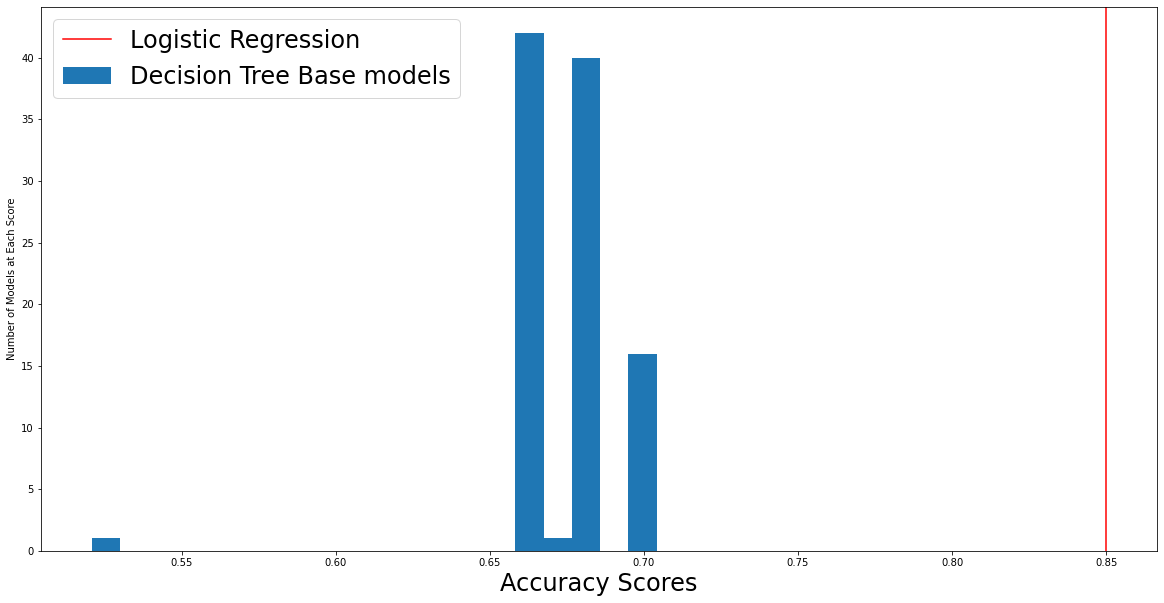

In [10]:
from sklearn.linear_model import LogisticRegressionCV

# get the accuracy score from logistic regression
# cross validation to determine the best regularization parameter, C
LR_score = LogisticRegressionCV().fit(X_train, y_train).score(X_test,y_test)

scores = []
for cur_model in models:
    scores.append(cur_model.score(X_test,y_test))

fig, ax = plt.subplots(1,1,figsize=(20,10))
ax.hist(scores,20, label="Decision Tree Base models");
ax.axvline(LR_score, color='red',label="Logistic Regression")
ax.set_xlabel('Accuracy Scores', fontsize=24) # DLS:  Added x-label
ax.set_ylabel("Number of Models at Each Score")
ax.legend(loc='best', fontsize=24)
plt.show()

To summarize the models, we have data frames recording each model's prediction on each point in the training/tuning/test set.

The 'tuning' set below is new. As mentioned, we need a set of data that isn't the training data, nor used to set hyperparameters in the original models (so, not the validation set), nor the final test data. We'll use this data in just a bit

In [11]:
predictions_train = pd.read_csv("data/predictions_train.csv", index_col=0)
predictions_tune = pd.read_csv("data/predictions_tune.csv", index_col=0)
predictions_test = pd.read_csv("data/predictions_test.csv", index_col=0)

predictions_tune.head()

,model0,model1,model2,model3,model4,model5,model6,model7,model8,model9,model10,model11,model12,model13,model14,model15,model16,model17,model18,model19,model20,model21,model22,model23,model24,model25,model26,model27,model28,model29,model30,model31,model32,model33,model34,model35,model36,model37,model38,model39,model40,model41,model42,model43,model44,model45,model46,model47,model48,model49,model50,model51,model52,model53,model54,model55,model56,model57,model58,model59,model60,model61,model62,model63,model64,model65,model66,model67,model68,model69,model70,model71,model72,model73,model74,model75,model76,model77,model78,model79,model80,model81,model82,model83,model84,model85,model86,model87,model88,model89,model90,model91,model92,model93,model94,model95,model96,model97,model98,model99
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
1,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


Considering the first row above, we see that model0 predicted the first tuning point to be class 0, model1 disagreed and thought it was class 1, and most of the other models think it's class 0. Other rows tell us about other observations in the tuning set.

### Combining the models
Perhaps the simplest way of combining the models' predictions (above) is a majority vote. Let's compute the test score under this rule

In [12]:
# axix = 1: get the mean along a row
meta_test_predictions = np.mean(predictions_test,axis=1) > 0.5  #do we have more than 50% 1s?
print("Test accuracy (Classify by majority vote): ", accuracy_score(y_test, meta_test_predictions))

Test accuracy (Classify by majority vote):  0.825


That's quite a bit better! The majority vote is scoring far better than any individual model.

**Note**:
- Working with probabilities is more information-rich. Especially in the two-class setting, predictions take probabilities like .51 and pretend that they're actually 1.0. You'll deal more with ensembling via probabilities on your homework. For now, we'll stick with the models' predictions.
- The Receiver Operating Characteristic Area Under the Curve (ROC AUC) is generally considered a more reliable metric than accuracy for a classification problem. Feel free to also use <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html" target="_blank">roc_auc(y_test, y_proba)</a> to score the models in this notebook.

** **

<div class="discussion"><b>Discussion</b></div>

**Q1.3** Suppose each modelling process reflected in the ensemble has the same bias and variance. How does majority voting affect combined bias and variance?

**Answer**:

If all models are biased to in the same way, the majority vote will reflect that. However, majority voting is able to reduce variance, and cancel out biases that run in multiple directions.

**Q1.4** Can you think of a weakness in majority voting? (Recall the original models that had less than 50% accuracy...)

**Answer**:

Majority voting gives the same weight to all model, even those that are known to underperform. We might prefer to pay more attention to the best-performing models.

### Complex combination rules
Let's try giving more weight to the models that are performing better. We already have the models' test-set performance in `scores` so let's use that... 

But wait! We would be using test data to (ultimately) help predict test data, and invalidate our model. And weighting via the training set performance would just say "listen to the most overfit model you can find, that guy's a genius." 

This is where the tuning set we left aside comes into play. It gives us a chance to measure how well each component model does on new data, without spoiling the test set. (If we had valid estimates of how well each model does out-of-sample, e.g. from out-of-bag estimates, we could use those to decide weights)

If we hadn't left a tuning set aside, we'd have to go back to the very beginning, set aside part of our training set to be the tuning set, and fit the base models to just the reduced training set.

**Speaker note**: point out that we've got the old one-tuning-set problem, and CV can assist

In [13]:
# get each model's overall performance on the tuning data
tuning_scores = [m.score(X_tune, y_tune) for m in models]

# divide by the sum so the weights all sum to 1.
weights = np.array(tuning_scores)/np.sum(tuning_scores)

print("First five weights:", weights[0:5])

# # on each tuning observation, apply the weight assigned to each model and predict as 1
# # if the weighted majority breaks 50%
# # np.dot performs matrix multiplication
weighted_predictions = np.dot(predictions_test, weights) > 0.5

test_acc = accuracy_score(y_test,weighted_predictions)
print(f'Test Acc: {test_acc:.3f}')

First five weights: [0.00981347 0.0103976  0.01008606 0.00961875 0.00996924]
Test Acc: 0.823


It turns out that weighting didn't change accuracy much. Though, to be fair, the weights are all basically .01, which is what they would be for a pure majority vote. Although we could spend time finding the right way to convert accuracy scores to weights, what we'd really like is to _learn the weights and threshold that are optimal for correctly classifying new points_. [Where have we heard _that_ before?] 

<div class="exercise"><b>Exercise</b></div>

**Q1.5** Create a logistic regression metamodel with ridge regularization to find weights for each of the 100 original models. You should use cross validation to tune the regularization.

In [14]:
# learn the optimal weights and intercept
# (intercept is related to whether we need a 50% majority or a 66% majority or an 80% majority)
# your code here
fitted_logreg = LogisticRegressionCV().fit(predictions_tune, y_tune)
print("Number of coeffecients: {} (One weight for each model)".format(fitted_logreg.coef_.shape[1]))

Number of coeffecients: 100 (One weight for each model)


**Q1.6** Combine the models using the weights you just found.

**Hint:** Don't over think it!

In [15]:
# use weights and intercept to combine the test data predictions
# your code here
y_hat = fitted_logreg.predict(predictions_test)

**Q1.7** Report the accuracy of the metamodel's predictions. How does it perform compared to the individual estimators and the the previous metamodels? What do you think explains this performance?

In [16]:
# evaluate logistic metamodel
# your code here
metalog_test_acc = accuracy_score(y_test, y_hat)

print(f"Test accuracy (LogReg on individual class predictions): {metalog_test_acc:.3f}")

# AUC just for fun!
y_hat_proba = fitted_logreg.predict_proba(predictions_test)[:,1]
metalog_test_auc = roc_auc_score(y_test, y_hat_proba)
print(f"Test AUC (LogReg on individual class predictions): {metalog_test_auc:.3f}")

#or just: fitted_logreg.score(predictions_test, y_test)

Test accuracy (LogReg on individual class predictions): 0.865
Test AUC (LogReg on individual class predictions): 0.933


**Answer:**

Paying more attention to the stronger models really improved our decisions! Keep in mind that almost none of models we combined could even beat logistic regression, but in concert they perform very well.

### More Information?

Up to this point we've been trying to find ways of combining the original models' _class predictions_ to improve our accuracy. But what we'd _really_ like to use are the models' _probability predictions_. This would give us much more information to work with.It would be important to know how confident each model is in its predictions.

In [17]:
def df_from_model_probas(models, X):
    '''
    Builds a Dataframes of probability predictions on X from a list of classifiers
    '''
    model_probas = [{f'model{i}': m.predict_proba(X)[:,1]} for i,m in enumerate(models)]
    df = pd.concat((pd.DataFrame(m) for m in model_probas), axis=1)
    return df

probas_train = df_from_model_probas(models, X_train)
probas_tune = df_from_model_probas(models, X_tune)
probas_test = df_from_model_probas(models, X_test)

probas_tune.head()

,model0,model1,model2,model3,model4,model5,model6,model7,model8,model9,model10,model11,model12,model13,model14,model15,model16,model17,model18,model19,model20,model21,model22,model23,model24,model25,model26,model27,model28,model29,model30,model31,model32,model33,model34,model35,model36,model37,model38,model39,model40,model41,model42,model43,model44,model45,model46,model47,model48,model49,model50,model51,model52,model53,model54,model55,model56,model57,model58,model59,model60,model61,model62,model63,model64,model65,model66,model67,model68,model69,model70,model71,model72,model73,model74,model75,model76,model77,model78,model79,model80,model81,model82,model83,model84,model85,model86,model87,model88,model89,model90,model91,model92,model93,model94,model95,model96,model97,model98,model99
0,0.28529,0.63986,0.322368,0.268750,0.302548,0.64455,0.273312,0.311628,0.288520,0.63512,0.643402,0.280120,0.279570,0.342342,0.282609,0.643720,0.284161,0.273006,0.639151,0.278027,0.287781,0.643743,0.651584,0.264984,0.269608,0.287338,0.266876,0.29142,0.296000,0.280360,0.633218,0.641791,0.288303,0.294815,0.302170,0.656180,0.286614,0.286344,0.670442,0.269113,0.625422,0.286604,0.285933,0.245819,0.633069,0.312883,0.655367,0.281298,0.283133,0.315789,0.285016,0.278638,0.315024,0.264310,0.264840,0.298300,0.286385,0.662177,0.264297,0.642384,0.627635,0.664452,0.313084,0.281931,0.258915,0.287023,0.274295,0.274194,0.297872,0.538095,0.295058,0.273463,0.648291,0.649824,0.634548,0.657658,0.671982,0.647458,0.651568,0.318393,0.290735,0.264062,0.283159,0.279503,0.62757,0.293355,0.627907,0.656422,0.640271,0.277070,0.272162,0.663265,0.647629,0.627451,0.310751,0.651242,0.641256,0.316358,0.644766,0.269537
1,0.66628,0.63986,0.667026,0.268750,0.671806,0.64455,0.638950,0.659933,0.671625,0.63512,0.643402,0.280120,0.640678,0.645977,0.641256,0.643720,0.658072,0.639140,0.639151,0.278027,0.648796,0.643743,0.651584,0.630820,0.640693,0.639130,0.634038,0.62907,0.616905,0.280360,0.633218,0.641791,0.654467,0.294815,0.640342,0.656180,0.645949,0.286344,0.670442,0.666667,0.625422,0.286604,0.638322,0.633262,0.633069,0.652715,0.655367,0.281298,0.283133,0.617371,0.285016,0.629213,0.636859,0.644374,0.662116,0.631046,0.647715,0.662177,0.647919,0.642384,0.627635,0.664452,0.626398,0.633110,0.631874,0.641317,0.643653,0.621179,0.621868,0.538095,0.295058,0.669935,0.648291,0.649824,0.634548,0.657658,0.671982,0.647458,0.651568,0.318393,0.627473,0.658482,0.283159,0.279503,0.62757,0.631121,0.315089,0.656422,0.640271,0.277070,0.627100,0.663265,0.647629,0.627451,0.661610,0.651242,0.641256,0.632883,0.644766,0.639164
2,0.66628,0.63986,0.667026,0.268750,0.671806,0.64455,0.638950,0.659933,0.288520,0.63512,0.643402,0.280120,0.640678,0.645977,0.641256,0.643720,0.284161,0.639140,0.639151,0.278027,0.648796,0.643743,0.651584,0.630820,0.640693,0.639130,0.266876,0.29142,0.616905,0.280360,0.633218,0.641791,0.654467,0.641115,0.640342,0.656180,0.645949,0.647953,0.670442,0.666667,0.625422,0.286604,0.638322,0.633262,0.633069,0.312883,0.655367,0.281298,0.283133,0.315789,0.285016,0.629213,0.315024,0.644374,0.662116,0.631046,0.647715,0.662177,0.647919,0.642384,0.627635,0.664452,0.626398,0.633110,0.631874,0.641317,0.643653,0.621179,0.297872,0.538095,0.626179,0.669935,0.648291,0.649824,0.634548,0.657658,0.671982,0.647458,0.651568,0.659168,0.290735,0.658482,0.631214,0.279503,0.62757,0.293355,0.627907,0.656422,0.640271,0.277070,0.627100,0.663265,0.647629,0.627451,0.661610,0.651242,0.641256,0.632883,0.644766,0.639164
3,0.28529,0.29056,0.667026,0.649554,0.671806,0.33815,0.638950,0.659933,0.288520,0.63512,0.256866,0.635321,0.640678,0.342342,0.282609,0.292373,0.284161,0.273006,0.300872,0.656286,0.287781,0.302003,0.297546,0.264984,0.640693,0.287338,0.266876,0.29142,0.296000,0.634062,0.266069,0.314286,0.654467,0.294815,0.640342,0.266254,0.286614,0.286344,0.297090,0.269113,0.264297,0.628635,0.638322,0.633262,0.633069,0.312883,0.267281,0.647919,0.650229,0.315789,0.644252,0.629213,0.315024,0.644374,0.264840,0.631046,0.286385,0.268217,0.

If you are having issues loading the sklearn models we've included the predicted probabilities you can load directly.

Just uncomment and run the code below

In [18]:
# probas_train.to_csv('data/probas_train.csv', index=False)
# probas_tune.to_csv('data/probas_tune.csv', index=False)
# probas_test.to_csv('data/probas_test.csv', index=False)

In [19]:
probas_train.head()

,model0,model1,model2,model3,model4,model5,model6,model7,model8,model9,model10,model11,model12,model13,model14,model15,model16,model17,model18,model19,model20,model21,model22,model23,model24,model25,model26,model27,model28,model29,model30,model31,model32,model33,model34,model35,model36,model37,model38,model39,model40,model41,model42,model43,model44,model45,model46,model47,model48,model49,model50,model51,model52,model53,model54,model55,model56,model57,model58,model59,model60,model61,model62,model63,model64,model65,model66,model67,model68,model69,model70,model71,model72,model73,model74,model75,model76,model77,model78,model79,model80,model81,model82,model83,model84,model85,model86,model87,model88,model89,model90,model91,model92,model93,model94,model95,model96,model97,model98,model99
0,0.66628,0.63986,0.322368,0.649554,0.671806,0.64455,0.273312,0.311628,0.671625,0.63512,0.643402,0.635321,0.279570,0.645977,0.641256,0.64372,0.658072,0.639140,0.639151,0.656286,0.648796,0.643743,0.651584,0.630820,0.269608,0.639130,0.634038,0.62907,0.616905,0.634062,0.633218,0.641791,0.288303,0.294815,0.640342,0.656180,0.645949,0.286344,0.670442,0.666667,0.625422,0.628635,0.638322,0.245819,0.633069,0.652715,0.655367,0.647919,0.650229,0.617371,0.644252,0.629213,0.636859,0.644374,0.662116,0.298300,0.647715,0.662177,0.647919,0.642384,0.627635,0.664452,0.313084,0.281931,0.631874,0.641317,0.643653,0.621179,0.621868,0.538095,0.295058,0.273463,0.648291,0.649824,0.634548,0.657658,0.671982,0.647458,0.651568,0.318393,0.627473,0.658482,0.283159,0.621076,0.62757,0.631121,0.315089,0.656422,0.640271,0.640969,0.627100,0.663265,0.647629,0.627451,0.661610,0.651242,0.641256,0.632883,0.644766,0.639164
1,0.28529,0.63986,0.322368,0.268750,0.302548,0.64455,0.273312,0.311628,0.288520,0.29742,0.256866,0.280120,0.279570,0.342342,0.282609,0.64372,0.284161,0.273006,0.639151,0.278027,0.287781,0.302003,0.297546,0.264984,0.269608,0.287338,0.266876,0.29142,0.296000,0.280360,0.266069,0.314286,0.288303,0.641115,0.302170,0.266254,0.286614,0.647953,0.297090,0.269113,0.264297,0.286604,0.285933,0.245819,0.324655,0.312883,0.267281,0.281298,0.283133,0.315789,0.285016,0.278638,0.315024,0.264310,0.264840,0.298300,0.286385,0.268217,0.264297,0.287302,0.294721,0.319115,0.313084,0.281931,0.258915,0.287023,0.274295,0.274194,0.297872,0.451149,0.626179,0.273463,0.297297,0.302190,0.313869,0.276235,0.671982,0.279570,0.281481,0.659168,0.290735,0.264062,0.631214,0.279503,0.62757,0.293355,0.627907,0.304000,0.282209,0.277070,0.272162,0.304281,0.251645,0.627451,0.310751,0.280000,0.276398,0.316358,0.250784,0.269537
2,0.66628,0.63986,0.322368,0.268750,0.302548,0.64455,0.273312,0.311628,0.288520,0.29742,0.643402,0.280120,0.279570,0.342342,0.641256,0.64372,0.284161,0.273006,0.639151,0.278027,0.648796,0.302003,0.297546,0.630820,0.269608,0.287338,0.266876,0.29142,0.296000,0.280360,0.633218,0.314286,0.288303,0.294815,0.302170,0.656180,0.286614,0.286344,0.670442,0.666667,0.264297,0.286604,0.285933,0.245819,0.324655,0.312883,0.267281,0.281298,0.283133,0.315789,0.285016,0.278638,0.315024,0.264310,0.662116,0.298300,0.647715,0.662177,0.264297,0.287302,0.627635,0.319115,0.313084,0.281931,0.631874,0.287023,0.274295,0.621179,0.297872,0.538095,0.295058,0.273463,0.648291,0.649824,0.313869,0.276235,0.671982,0.647458,0.281481,0.318393,0.290735,0.264062,0.283159,0.279503,0.62757,0.293355,0.627907,0.304000,0.640271,0.277070,0.627100,0.304281,0.251645,0.627451,0.310751,0.280000,0.276398,0.632883,0.644766,0.269537
3,0.66628,0.63986,0.667026,0.649554,0.302548,0.64455,0.638950,0.659933,0.288520,0.29742,0.643402,0.635321,0.640678,0.645977,0.641256,0.64372,0.284161,0.639140,0.639151,0.656286,0.648796,0.643743,0.651584,0.630820,0.640693,0.639130,0.266876,0.29142,0.616905,0.634062,0.633218,0.641791,0.654467,0.294815,0.302170,0.656180,0.645949,0.286344,0.670442,0.666667,0.625422,0.628635,0.285933,0.633262,0.324655,0.312883,0.655367,0.647919,0.650229,0.315789,0.644252,0.278638,0.315024,0.264310,0.662116,0.631046,0.647715,0.662177,0.2642

**Q1.8** Fit a 2nd logistic metamodel, this time on the probability predictions. How does it perform?

In [20]:
# learn the optimal weights and intercept
# (intercept is related to whether we need a 50% majority or a 66% majority or an 80% majority)
# your code here
logreg_proba = LogisticRegressionCV().fit(probas_tune, y_tune)

# use weights and intercept to combine the test data predictions
# your code here
y_hat = logreg_proba.predict(probas_test)

# evaluate logistic metamodel
# your code here
metalog_proba_test_acc = accuracy_score(y_test, y_hat)
print(f"Test accuracy (LogReg on individual probability predictions): {metalog_proba_test_acc:.3f}")

y_hat_proba = logreg_proba.predict_proba(predictions_test)[:,1]
metalog_proba_test_auc = roc_auc_score(y_test, y_hat_proba)
print(f"Test AUC (LogReg on individual class predictions): {metalog_proba_test_auc:.3f}")

Test accuracy (LogReg on individual probability predictions): 0.856
Test AUC (LogReg on individual class predictions): 0.932


**Answer:**

We actually do a bit worse. Chances are we've overfit a little bit with our probability model.

In [21]:
print(f'Class Label Model - Tune Score: {fitted_logreg.score(predictions_tune, y_tune):.3f}')
print(f'Probabilities Model - Tune Score: {logreg_proba.score(probas_tune, y_tune):.3f}')

Class Label Model - Tune Score: 0.846
Probabilities Model - Tune Score: 0.849


That does seem to be the case here.

We'll use the probabilities for training our metamodels from here on. To keep things simple we'll rename the dataframes to go back the the `predictions_...` convention. You can always experiment with using the class labels on the rest of the notebook by setting `USE_PROBAS` to False and re-running.

In [22]:
USE_PROBAS = True
if USE_PROBAS:
    predictions_tune = probas_tune
    predictions_train = probas_train
    predictions_test = probas_test

**Q1.8** How well does a decision tree do at combining the models? (Be careful about how you pick your parameters. Again, they should be tuned with cross validation)

**Hint:** There is no CV version of the decision tree in SKLearn like there is for logistic regression. You'll need to use something like `cross_val_scores` instead.

In [23]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
# your code here

for cur_depth in range(1,8):
    model = DecisionTreeClassifier(max_depth = cur_depth)
    scores = cross_val_score(model, predictions_tune, y_tune, cv=5)
    print("depth = {}: ACC {:.3f} +/- {:.3f}".format(cur_depth, np.mean(scores), np.std(scores)))

dt_test_acc = DecisionTreeClassifier(max_depth=4).fit(predictions_tune, y_tune).score(predictions_test, y_test)
print(f"Test accuracy (Decision Tree on individual predictions): {dt_test_acc:.3f}")

depth = 1: ACC 0.719 +/- 0.052
depth = 2: ACC 0.714 +/- 0.047
depth = 3: ACC 0.740 +/- 0.057
depth = 4: ACC 0.750 +/- 0.052
depth = 5: ACC 0.766 +/- 0.039
depth = 6: ACC 0.750 +/- 0.051
depth = 7: ACC 0.742 +/- 0.051
Test accuracy (Decision Tree on individual predictions): 0.750


**Answer:**

We don't do as well as the logistic model. But what if we used multiple tree? An ensemble of models predicting on the predictions of an ensemble of models. Pretty meta! That's where we'll go next.

**Return to the main Zoom room** :) 

Importantly, any parameter hunting we do for the meta-model needs to be done via data from the tuning set. We're not allowed to peek at the test set, and the training set has already been used to tune and fit the base models. *All meta-parameters are found via the tuning set*.

**Speaker note**: talk about building the models yourself, e.g. combining well-tuned RF to get a good combined model 

### Summary of Ensembling
- Ensemble models can be understood as building a bunch of models on the training data and combining them somehow
- Visually, you can imagine a dataset consisting of each model's prediction or (if available) its probability estimate for each data point
- The art of ensembling is in building models that complement each other, and picking a rule to combine them
- You can even use the data to tell you what the combination rule should be, but you have to use data separate from the training and test sets to learn this rule. Simply combining the models via linear/logistic regression is a popular choice.

## Part 2: Bagging & Hyperparameter Tuning
You've been working with bootstrapping since the beginning of the course, so you should be a pro when it comes to bagging. Remember that random forests are a generalization of bagged trees.



### Tuning the hyperparameters

Random Forests generally perform very well out-of-the-box, with the sklearn's default hyperparameters. Some of the tunable parameters are:
- The number of trees in the forest: `n_estimators`, int, default=100
- The complexity of each tree: 
    - stop when a leaf has <= `min_samples_leaf` samples 
    - the `max_depth` of each tree
- The sampling scheme: number of features to consider at any given split: `max_features` {“auto”, “sqrt”, “log2”}, int or float, default=”auto”.

#### Hints:

<a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html" target="_blank">RandomForestClassifier()</a> : Defines the RandomForestClassifier and includes more details on the definition and range of values for its tunable parameters.

<a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.predict_proba" target="_blank">model.predict_proba(X)</a> : Predict class probabilities for X

### Vanilla random forest

We'll start by training a Random Forest Classifier using the default parameters and calculate the test accuracy.

In [24]:
from sklearn.ensemble import RandomForestClassifier
seed = 0
# Define a Random Forest classifier with randon_state = seed
vanilla_rf = RandomForestClassifier(random_state=seed) 

# Fit the model on the entire data
vanilla_rf.fit(predictions_tune, y_tune);

# Calculate ACC & AUC/ROC on the test set
y_proba = vanilla_rf.predict_proba(predictions_test)[:, 1]
acc = accuracy_score(y_test, y_proba > 0.5)
auc = roc_auc_score(y_test, y_proba)
print(f'Vanilla RF ACC on test set:{acc:.3f}')
print(f'Vanilla RF AUC on test set:{auc:.3f}')

Vanilla RF ACC on test set:0.819
Vanilla RF AUC on test set:0.906


### Number of trees, `n_estimators`, default = 100

Trees in a RF are called _estimators_.
One way to tune our random forest classifer's `n_estimators` hyperparameter is to:
1. iterate over candidate values 
2. instantiate a classifer with current value
3. pass the classifer to `cross_val_score`

In [25]:
%%time
import sklearn
min_estimators = 50
max_estimators = 500
step_estimators = 50
n_estimators_list = np.arange(min_estimators, max_estimators+1, step_estimators)
cvmeans = []
for n_estimators in n_estimators_list:
    clf = RandomForestClassifier(n_estimators=n_estimators, max_depth = 10, max_features='auto', warm_start=True, random_state=seed)
    # Perform 5-fold cross validation and store results
    scores = cross_val_score(estimator=clf, X=predictions_tune, y=y_tune, cv=5)
    cvmeans.append(scores.mean())
    print("n_estimators =", n_estimators,": val_accuracy =",scores.mean())

n_estimators = 50 : val_accuracy = 0.7916267942583731
n_estimators = 100 : val_accuracy = 0.8046138072453862
n_estimators = 150 : val_accuracy = 0.7968215994531784
n_estimators = 200 : val_accuracy = 0.7968215994531784
n_estimators = 250 : val_accuracy = 0.799419002050581
n_estimators = 300 : val_accuracy = 0.8020164046479836
n_estimators = 350 : val_accuracy = 0.8046138072453862
n_estimators = 400 : val_accuracy = 0.8020164046479836
n_estimators = 450 : val_accuracy = 0.8020164046479836
n_estimators = 500 : val_accuracy = 0.804647983595352
CPU times: user 18.6 s, sys: 204 ms, total: 18.8 s
Wall time: 18.9 s


This can be rather slow, especially if we are using a large number of estimators and/or there are many candidate values we'd like to try.

<div class="discussion"><b>Discussion</b></div>

**Q2.1**: Why do you think cross validation might be slow with random forests?

**Answer:**

You have to bootstrap all n_estimators on each validation fold! We're also redeclaring our classifier on each iteration. Worse yet, we refit the base trees unnecessarily when we move on to try a new number of estimators! For example, after we complete the 50 estimator model, when we start the 100 estimator model, we refit the first 50 trees again! What a waste! In the next example, we'll see how the `warm_start` parameter can solve this problem.

**Q2.2**: We have this this `predictions_train` dataframe from earlier. Considering what's been said about the tuning data, can you think of any future use for `preductions_train`?

**Answer:**

Perhaps as a way of assessing which models are overfit to the original training data. But we definitely don't want to train or tune our metamodel on it!

### OOB Error

A faster option is to use _out-of-bag error (oob)_ to evaluate each candidate hyperparameter value.

Recall that when bootstrapping each estimator in the RF, some observations will not be sampled. Because the estimator wasn't fit on these observations they can be used as a 'free' validation set!

The number of estimators (i.e., trees) needs to be large enough for the $oob$ error to stabilize in its lowest possible value. A good start is 10 times the number of features, however, adjusting other hyperparameters will influence the optimum number of trees (more on that shortly!). 

**Note:** 
* The RF has an `oob_score_` attribute. This is the _oob accuracy_. How would you get the _oob error rate_?
* Instantiating the RF classifer inside the loop at each iteration slows things down. We can instead instantiate the RF _before_ the loop and simply change any parameter values we like from inside the loop using the classifier's `set_params()` method.

In [26]:
%%time
clf = RandomForestClassifier(warm_start=True, 
                               oob_score=True,
                               min_samples_leaf=40,
                               max_depth = 10,
                               random_state=seed)

error_rate = {}

for i in range(min_estimators, max_estimators + 1):
    clf.set_params(n_estimators=i) 
    clf.fit(predictions_tune, y_tune)

    # Record the OOB error for each `n_estimators=i` setting.
    oob_error = 1 - clf.oob_score_
    error_rate[i] = oob_error

CPU times: user 39 s, sys: 781 ms, total: 39.7 s
Wall time: 40 s


**Q2.3**: WHat does the `warm_start` parameter do? 

**Answer:**

If the classifier already has trees `n_estimators`-1 estimators, it simply adds a new one rather than building them all up again. Much faster!

Now we can plot the $oob$ error of a random forest as a function of the number of trees

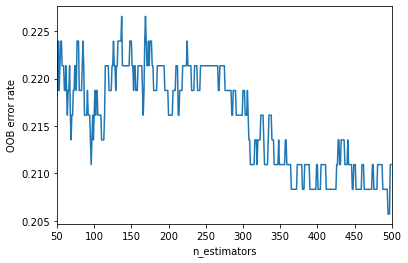

In [27]:
# Generate the "OOB error rate" vs. "n_estimators" plot.
# OOB error rate = num_missclassified/total observations (%)\
xs = []
ys = []
for label, clf_err in error_rate.items():
    xs.append(label)
    ys.append(clf_err)   
plt.plot(xs, ys)
plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.show()

Weevaluated just fit and evaluated 50x the number of models in just twice the time!

### `min_samples_leaf`, default = 1

The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression. We will plot various values of the `min_samples_leaf` with `num_iterators`. 

**Note:** This takes about 2 minutes to run. We can use that time to understand the code! :)

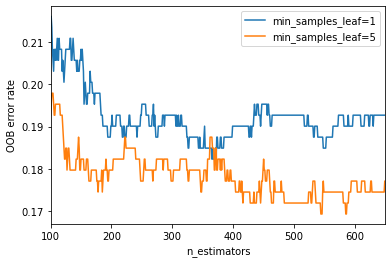

CPU times: user 2min 9s, sys: 2.36 s, total: 2min 11s
Wall time: 2min 12s


In [28]:
%%time
# runtime ~2 minutes
from collections import OrderedDict
# instantiate the template classifier
clf = RandomForestClassifier(oob_score=True,
                             max_depth = 10,
                             random_state=seed)

# set some hyperparameter candidates
min_estimators = 100
max_estimators = 650
min_samples_leaf_list = [1, 5]

# Map a label (the value of `min_samples_leaf`) to a list of (model, oob error) tuples.
# error_rate = OrderedDict((label, []) for label in min_samples_leaf_list)
error_rate = {label: [] for label in min_samples_leaf_list}

for min_samples_leaf in min_samples_leaf_list:
    clf.set_params(min_samples_leaf=min_samples_leaf) 
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i) 
        clf.fit(predictions_tune, y_tune)
        # Record the OOB error for each model
        oob_error = 1 - clf.oob_score_
        error_rate[min_samples_leaf].append((i, oob_error))
        # warm_start is complicated if we when looping over
        # other parameters in addition to n_estimators
        clf.set_params(warm_start=True)
    clf.set_params(warm_start=False)

for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=f'min_samples_leaf={label}')

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

We can then look at the lowest error to choose our parameters.

In [29]:
err = 100
best_num_estimators = 0
for label, clf_err in error_rate.items():
    num_estimators, error = min(clf_err, key=lambda n: (n[1], -n[0]))
    if error<err: err=error; best_num_estimators = num_estimators; best_leaf = label

print(f'Optimum num of estimators: {best_num_estimators} \nmin_samples_leaf: {best_leaf}')

Optimum num of estimators: 586 
min_samples_leaf: 5


Now we re-train the Random Forest Classifier using the new values for the parameters and calculate the AUC/ROC. Include another parameter, the `max_features`, the number of features to consider when looking for the best split. 

In [30]:
estimators_rf = RandomForestClassifier(n_estimators= best_num_estimators,
                                    random_state=seed,
                                    oob_score=True,
                                    min_samples_leaf=best_leaf,
                                    max_features='sqrt') 

# Fit the model on the entire data
estimators_rf.fit(predictions_tune, y_tune);

# # Calculate accuracy
# y_pred = estimators_rf.predict(X_test)
# acc = np.round(estimators_rf.score(X_test, y_test),2)
# print(f'Plain RF accuracy on test set:{acc}')

# Calculate AUC/ROC
y_proba = estimators_rf.predict_proba(predictions_test)[:, 1]
estimators_acc = accuracy_score(y_test, y_proba > 0.5)
estimators_auc = np.round(roc_auc_score(y_test, y_proba),2)
print(f'Educated RF ACC on test set:{estimators_acc:.3f}')
print(f'Educated RF AUC on test set:{estimators_auc:.3f}')

Educated RF ACC on test set:0.833
Educated RF AUC on test set:0.920


Look at the model's parameters with `get_params()`

In [31]:
estimators_rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 586,
 'n_jobs': None,
 'oob_score': True,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

### GridSearchCV

After we have some idea of the range of optimum values for the number of trees and maybe a couple of other parameters, and have enough computing power, you may perform an exhaustive search over other parameter values.

<a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html" target="_blank">GridSearchCV()</a> : Performes exhaustive search over specified parameter values for an estimator.

In [32]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# not that warm_start isn't useful if we are not tuning num_estimators
rf = RandomForestClassifier(n_jobs=-1,
                           n_estimators= best_num_estimators,
                           oob_score=True,
                           min_samples_leaf=best_leaf,
                           random_state=seed)

param_dict = {
    'min_samples_split': [2,5],
    'max_features': ['sqrt', predictions_tune.shape[1], predictions_tune.shape[1]//2]
}

scoring = {'ACC': make_scorer(accuracy_score), 'AUC': 'roc_auc'}

grid_search = GridSearchCV(rf, 
                           param_dict, 
                           scoring=scoring, 
                           refit='ACC', 
                           return_train_score=True, 
                           n_jobs=-1)

results = grid_search.fit(predictions_tune, y_tune)
best_rf = results.best_estimator_
display.display(best_rf.get_params())
# Calculate AUC/ROC
y_proba = best_rf.predict_proba(predictions_test)[:, 1]
grid_acc = accuracy_score(y_test, y_proba > 0.5)
grid_auc = roc_auc_score(y_test, y_proba)
print(f'GridSearchCV RF ACC on test set:{grid_acc:.3f}')
print(f'GridSearchCV RF AUC on test set:{grid_auc:.3f}')

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 586,
 'n_jobs': -1,
 'oob_score': True,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

GridSearchCV RF ACC on test set:0.833
GridSearchCV RF AUC on test set:0.923
CPU times: user 1.31 s, sys: 429 ms, total: 1.74 s
Wall time: 17.8 s


That was pretty quick! But if we wanted to search tune more parameters the number of combinations quickly gets large and we'd really start to notice cross validation slowing us down.

## Skip the CV with ParameterGrid!

[ParameterGrid](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ParameterGrid.html) creates a generator of dictionaries from your original `param_dict`, one dictionary for each combination of parameters!

Now we can just loop over this generator, using `set_params()` and `oob_score_` without having to be slowed down by cross validation. It's the best of both worlds!

In [33]:
%%time
# runtime ~1 minute
from sklearn.model_selection import ParameterGrid

param_dict = {
    'n_estimators': [550, 575, 586, 600],
    'min_samples_split': [2,5],
    'max_features': ['sqrt', predictions_tune.shape[1], predictions_tune.shape[1]//2]
}
param_grid = ParameterGrid(param_dict)

clf = RandomForestClassifier(n_jobs=-1,
                               n_estimators = best_num_estimators,
                               oob_score = True,
                               warm_start=  True,
                               min_samples_leaf=best_leaf,
                               random_state=seed)
error = 100
max_estimators = max([params['n_estimators'] for params in param_grid])
best_params = {}
for params in param_grid:
    clf.set_params(**params)
    clf.fit(predictions_tune, y_tune)
    # Record the OOB error for each model
    oob_error = 1 - clf.oob_score_
    if oob_error < error:
        best_params = clf.get_params()
        if params['n_estimators'] == max_estimators:
            clf.set_params(warm_start=False)
        else:
            clf.set_params(warm_start=True)

CPU times: user 12.3 s, sys: 1.8 s, total: 14.1 s
Wall time: 12.5 s


In [34]:
pgrid = clf.set_params(**best_params)
y_proba = pgrid.predict_proba(predictions_test)[:,1]
pgrid_acc = accuracy_score(y_test, y_proba > 0.5)
pgrid_auc = roc_auc_score(y_test, y_proba)
display.display(best_params)
print(f'ParamGrid RF ACC on test set:{pgrid_acc:.3f}')
print(f'ParamGrid RF AUC on test set:{pgrid_auc:.3f}')

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 50,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 5,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 600,
 'n_jobs': -1,
 'oob_score': True,
 'random_state': 0,
 'verbose': 0,
 'warm_start': True}

ParamGrid RF ACC on test set:0.831
ParamGrid RF AUC on test set:0.913


## Part 3: Boosting
We wanted to spend a few more words on boosting, since it can sometimes take a second pass to make sense of it.

Boosting is a particular way of building and combing the models in an ensemble. Most ensemble models don't care about the order the models are built in, but in boosting we train a sequence of models where each later model tries to do well on the data points that the current team of models isn't getting right.

In [35]:
x = np.arange(0, 2*np.pi, 0.1)
y = np.sin(x) + 0.1*np.random.normal(size=x.shape[0])

In [36]:
from sklearn.ensemble import GradientBoostingRegressor
estgb = GradientBoostingRegressor(n_estimators=501, max_depth=1, learning_rate=1)
estgb.fit(x.reshape(-1,1), y);

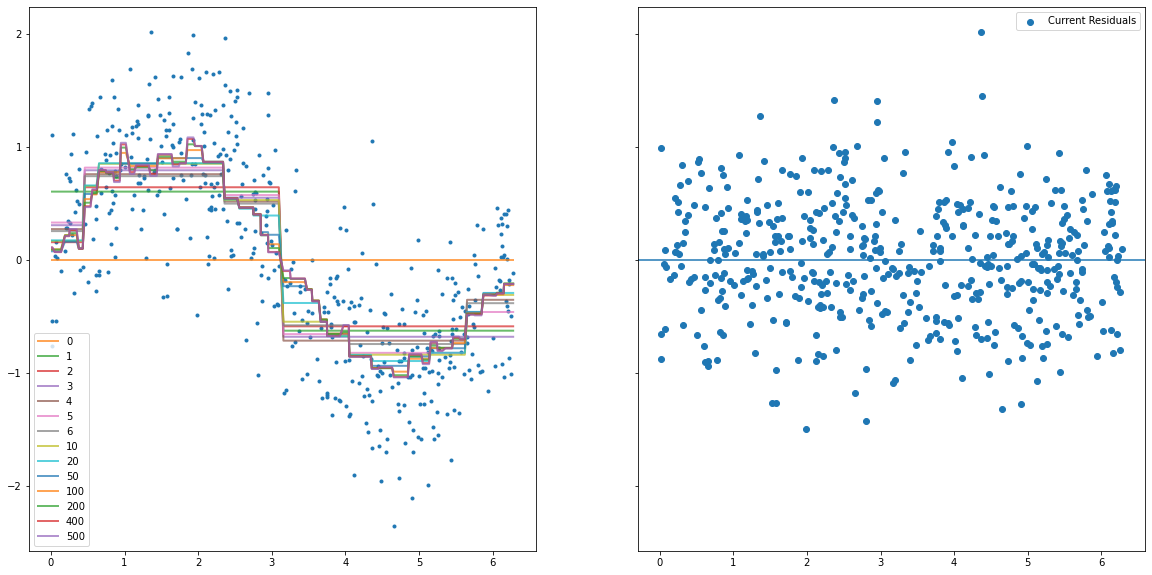

In [50]:
import time
display_iters = [0, 1, 2, 3, 4, 5, 6, 10, 20, 50, 100, 200, 400, 500]

def staged_fit_plot(estgb, x, y, display_iters):
    # code from http://nbviewer.jupyter.org/github/pprett/pydata-gbrt-tutorial/blob/master/gbrt-tutorial.ipynb
    fig, ax = plt.subplots(1,2, figsize=(20,10), sharey=True)
    ax[0].plot(x, y, '.');

    sleep_time = 2

    # the predicitions given by staged_predict skips the intial predict-the-mean model, so put it back
    overall_predictions = list(estgb.staged_predict(x.reshape(-1,1)))
    overall_predictions = [np.mean(y)*np.ones_like(x)] + overall_predictions

    # for various points in the run
    for i in display_iters:

        # plot the current overall prediction in the left panel
        cur_overall_prediction = overall_predictions[i]
        ax[0].plot(x, cur_overall_prediction, alpha=0.7, label=str(i), lw=2)
        ax[0].legend()

        # plot the current residuals in the right panel
        resid = y - cur_overall_prediction
        ax[1].cla()
        ax[1].scatter(x,resid, label="Current Residuals")
        ax[1].axhline(0)

        # if early, also plot the model fitted to these residuals
        if i <=5:
            cur_est = estgb.estimators_[i,0]
            cur_prediction = cur_est.predict(x.reshape(-1,1))
            ax[1].plot(x, cur_prediction, color='orange', label="Newest Model")
        else:
            # if late, accalerate
            sleep_time = sleep_time/2
        ax[1].legend()

        # plot
        display.display(fig)
        display.clear_output(wait=True)
        time.sleep(sleep_time)

staged_fit_plot(estgb, x, y, display_iters)

In the left panel, we see an animated version of the slides from class: as we run boosting, the overall model fits (and overfits) the data better and better. In the right panel, we can see the residuals left by the current model, and the model fit to them. At each iteration, $\text{learning_rate}\cdot\text{right_panel_model}$ is added to the latest line in the left panel. You can see how the newest model (right panel) determines how much the overall model (left panel) changes, and why Boosting might be connected to derivatives and gradients.

<div class="exercise"><b>Exercise</b></div>

**Q3.1** What is the effect does the learning rate <1 have on the overall model?

**Answer**:

The overall model updates more slowly. Only a fraction of the latest fit is incorporated

**Q3.2.** What changes when we use a max_depth of 2 or 3?

**Answer:**

The latest models are allowed to be more flexible, consisting of 4 or 8 flat lines instead of just two.

### Tuning a Boosted Model
Now you should try fine tuning a boosted model like the one above using some form of grid search (the `ParameterGrid` method is recommended). Some parameters to play with would be `n_estimators`, `max_depth`, and `learning_rate`. 

**Q3.3** Save your tuned GradientBoostingRegressor object as `gboost` and store its best parameters as `best_params`

**Note:** We've added more data points and more noise to keep things interesting!

**Hints:** 
- You will have to `reshape(-1,1)` the `x` matrix when fitting and predicting, just as in the code above.
- Take a look at the [GradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html?highlight=gradientboost#sklearn.ensemble.GradientBoostingRegressor) documentations for more options.
- Refer to the RF GridSearch code above for guidance

In [38]:
NOISE_SCALE = 0.5
N_POINTS = 2500
x = np.linspace(0, 2*np.pi, N_POINTS)
y = np.sin(x) + NOISE_SCALE*np.random.normal(size=x.shape[0])

def sorted_split(x, y, test_size):
    '''
    We want to shuffle our data when we split.
    But this can result in spaghetti plots later!
    This helper function sorts the results of our splits for us
    '''
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2)
    train_sort_idx = np.argsort(x_train)
    x_train = x_train[train_sort_idx]
    y_train = y_train[train_sort_idx]
    test_sort_idx = np.argsort(x_test)
    x_test = x_test[test_sort_idx]
    y_test = y_test[test_sort_idx]
    return x_train, x_test, y_train, y_test
    
    
x_train, x_test, y_train, y_test = sorted_split(x, y, test_size=.2)
# if you use cross validation, you won't need a separate validation set!
x_train, x_val, y_train, y_val = sorted_split(x_train, y_train, test_size=.2)

In [39]:
%%time
# your code here
param_grid = ParameterGrid({'n_estimators': [800, 900, 1000],
                            'max_depth': [1, 2],
                            'learning_rate': [0.6, 0.5, 0.4]})

gboost = GradientBoostingRegressor()
error = 100
best_params = {}
for params in param_grid:
    gboost.set_params(**params)
    gboost.fit(x_train.reshape(-1,1),y_train)
    # Record the OOB error for each model
    if (1-gboost.score(x_val.reshape(-1,1), y_val)) < error:
        best_params = gboost.get_params()

CPU times: user 6.64 s, sys: 21.4 ms, total: 6.66 s
Wall time: 6.68 s


Let's take a look at `best_params` and make sure `gboost` is using them!

In [40]:
display.display(best_params)
gboost.set_params(**best_params)

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.4,
 'loss': 'ls',
 'max_depth': 2,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

GradientBoostingRegressor(learning_rate=0.4, max_depth=2, n_estimators=1000)

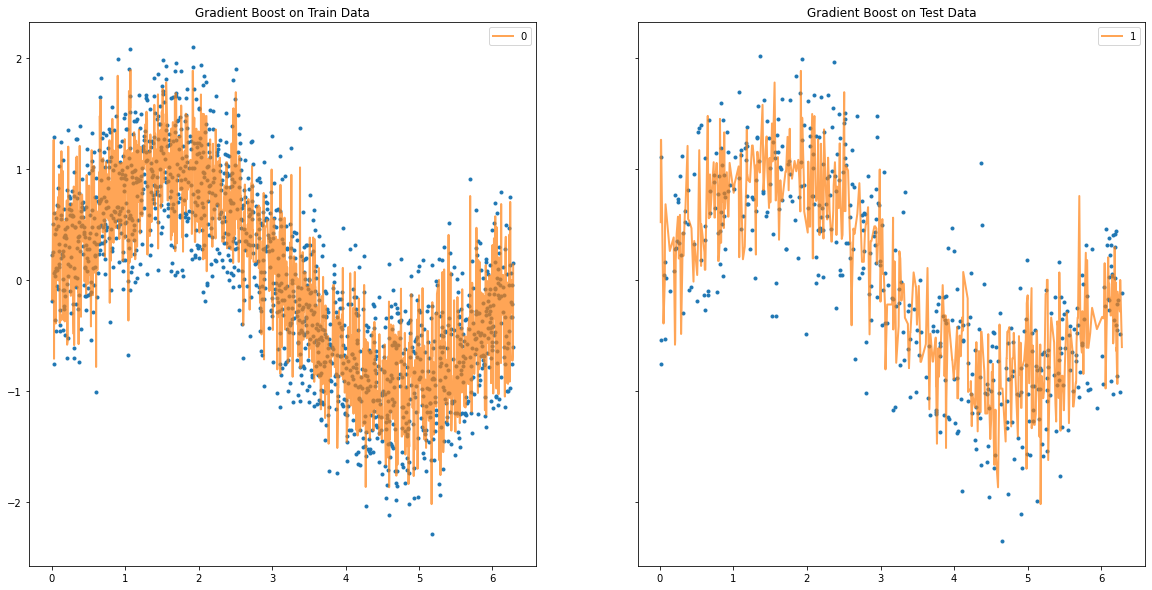

In [41]:
fig, ax = plt.subplots(1,2, figsize=(20,10), sharey=True)
for i, (x, y, title) in enumerate(zip([x_train, x_test], [y_train, y_test], ['Train', 'Test'])):
    ax[i].plot(x, y, '.');
    ax[i].plot(x, gboost.predict(x.reshape(-1,1)), alpha=0.7, label=str(i), lw=2)
    ax[i].set_title(f'Gradient Boost on {title} Data')
    ax[i].legend();

In [42]:
print('Train R^2:', gboost.score(x_train.reshape(-1,1), y_train)) 
print('Val   R^2:', gboost.score(x_val.reshape(-1,1), y_val))
print('Test  R^2:', gboost.score(x_test.reshape(-1,1),y_test))

Train R^2: 0.964378809508851
Val   R^2: 0.49201639756077464
Test  R^2: 0.4788427112355379


The problem with the above method is that we only have a single validation set. Best to use cross validation instead! 

But we can't use _oob error_ on this problem because we aren't bootstrapping. So this is a senario in which we should probably use `GridSearchCV`.

In [43]:
# add validation back into our training data
x_train = np.concatenate([x_train, x_val])
y_train = np.concatenate([y_train, y_val])
# but we need to re-sort!
idxs = np.argsort(x_train)
x_train = x_train[idxs]
y_train = y_train[idxs]

We'll also adjustthe parameters we search over based on our previous results. Notice that the lowest learning rate and high number of estimators were selected. We're likely still overfitting so we should add lower learning rates and an extended range of `n_estimators` to our parameter search.

In [44]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# not that warm_start isn't useful if we are not tuning num_estimators

param_dict = {'n_estimators': [500, 600, 700, 800, 900, 1000, 1250, 1500, 2000],
              'learning_rate': [0.1, 0.05, 0.025, 0.01, 0.005]}

gboost = GradientBoostingRegressor(max_depth=1)

grid_search = GridSearchCV(estimator=gboost, 
                           param_grid=param_dict, 
                           return_train_score=True,
                           cv=5,
                           n_jobs=-1)

results = grid_search.fit(x_train.reshape(-1,1), y_train)
# get the best estimator from our GridSearch
gboost = results.best_estimator_

CPU times: user 1.24 s, sys: 43.7 ms, total: 1.29 s
Wall time: 23.8 s


In [45]:
best_params = gboost.get_params()
display.display(best_params)

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.05,
 'loss': 'ls',
 'max_depth': 1,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1250,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

If you like, you can view the boosting animation on your own tuned model with the cell below. Watch those residuals shrink!

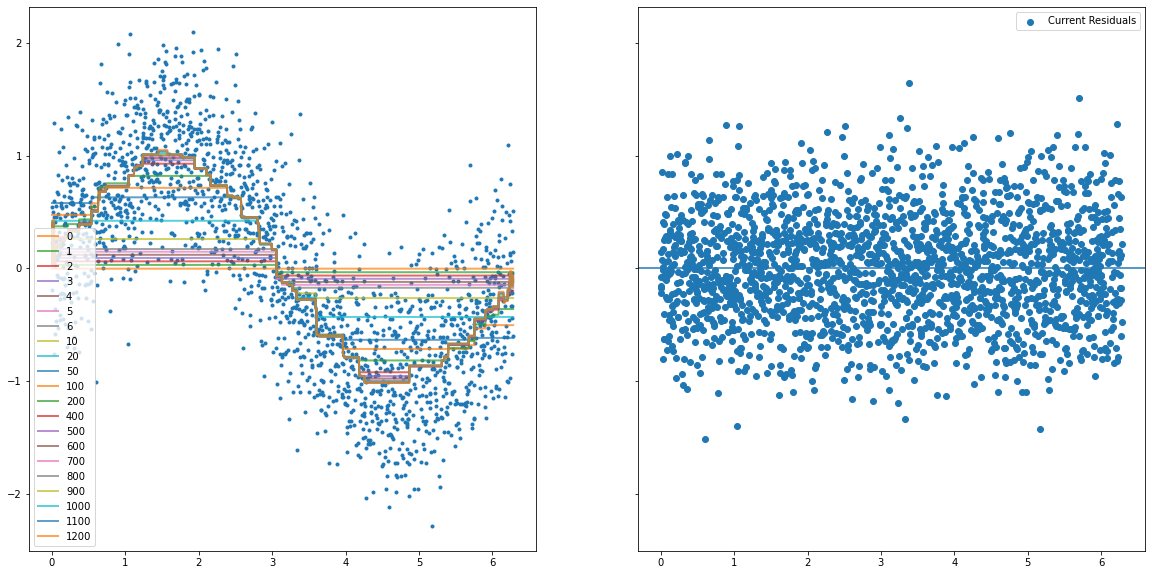

In [46]:
n_estimators = best_params['n_estimators']
if n_estimators > max(display_iters):
    display_iters = display_iters[:-1] + list(np.arange(max(display_iters), n_estimators+1, 100))
staged_fit_plot(gboost, x_train, y_train, display_iters=display_iters)

How did you do? Are you overfitting? Below you can view the model predictions on train and test side-by-side as well as the accuracy on all 3 datasets.

**Q3.4** Revisit your gridsearch above and tweak the parameters you are searching over. What's the best test score you can achieve? 

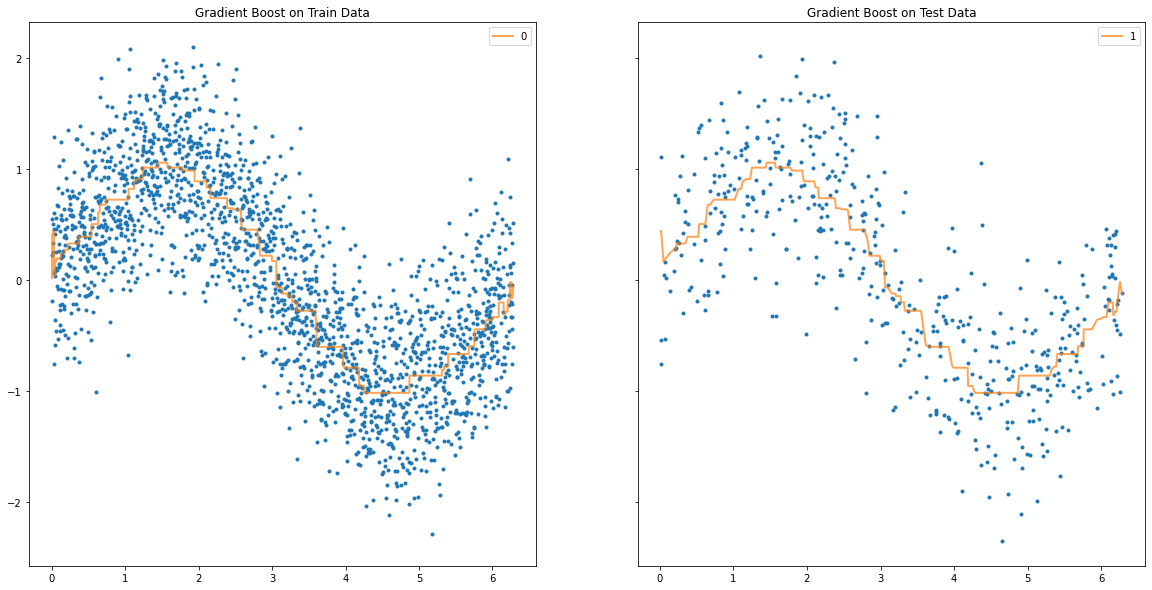

In [47]:
fig, ax = plt.subplots(1,2, figsize=(20,10), sharey=True)
for i, (x, y, title) in enumerate(zip([x_train, x_test], [y_train, y_test], ['Train', 'Test'])):
    ax[i].plot(x, y, '.');
    ax[i].plot(x, gboost.predict(x.reshape(-1,1)), alpha=0.7, label=str(i), lw=2)
    ax[i].set_title(f'Gradient Boost on {title} Data')
    ax[i].legend();

In [48]:
print('Train R^2:', gboost.score(x_train.reshape(-1,1), y_train)) 
print('Test  R^2:', gboost.score(x_test.reshape(-1,1),y_test))

Train R^2: 0.6990735110488979
Test  R^2: 0.6706686785107855


**Please return to the main Zoom room :)**

### Summary of Bagging and Boosting
- Bagging and boosting both build ensemble models in special ways
  - Thus, they each have a specific way of building new models, and a speciefic way of combining them
  - The homework has you explore thier relationship much more deeply